# Example simulation script in (2+1)-dimensional settings
In this notebook we implement a (2+1)-dimensional simulation and employ some post-processing methodologies;

In [1]:
import os
from scipy import *
from numpy import *
from pylab import *
import arrayfire as af
from core_libs.bindings import *
from core_libs.af_loader import *

## Start a simulation mesh
Define the simulation box parameters

In [2]:
#number of transversal dimensions (only working 1 and 2, necessary for plotting)
dims = 2

#Number of points in x,y transversal dimensions
Nx = 512
Ny = 256

#do not change Nt, Nz
Nt = 1 
Nz = 1

#spatial steps
dx = 1.
dy = 1.
dt = 1.

#integration parameters

total_steps = 40
stride = 40
dz = 0.2

#define a directory to save
saveDir = "data1"


my_simulation = simulation_config(dims, Nx, Ny, Nt, Nz, total_steps, 
                                  stride,dx,dy,dz,dt,0,0, saveDir)


## Initial condition
Define the initial condition

In [3]:
#a simple gaussian function in 2d
def gaussian_2d_field(x_af,y_af,A,w,x0,y0,vx,vy):
    new_field = A*af.exp(-((x_af - x0)*(x_af - x0)+ (y_af - y0)*(y_af - y0)) / 
                                    (w*w))*af.exp(1.0j*(vx*(x_af-x0)+ vy*(y_af-y0)))
    return new_field

def planewave_2d_field(x_af,y_af,A,vx):
    new_field = A*af.exp(1.0j*(vx*(x_af)))
                         
    return new_field

def planewave_vortex(x_af,y_af,w,x0,y0,A,m):
    r = af.sqrt((x_af-x0)**2+(y_af-y0)**2)
    theta = af.atan((y_af-y0)/(x_af-x0+0.001))
    new_field = A+af.exp(1j*m*theta)                
    return new_field 

def whitenoise_2d_field(x_af,A):
    new_field = A*af.randu(my_simulation.x_af.dims()[0],my_simulation.x_af.dims()[1])
                         
    return new_field

                         
#my_simulation.initial_condition.add_field(gaussian_2d_field(my_simulation.x_af,my_simulation.y_af,
#                                                            1.0,200.,
#                                                            my_simulation.Nx*dx/2,my_simulation.Ny*dy/2,1.5,0))

nxx=130
vx_planewave = 2*pi * nxx / (Nx*dx)#setting a planewave requires a multiple of 2pi/Lx due to native periodic boundary conditions
print("vx_planewave = " + str(vx_planewave))
my_simulation.initial_condition.add_field(planewave_2d_field(my_simulation.x_af,my_simulation.y_af,1.,vx_planewave))
my_simulation.initial_condition.add_field(whitenoise_2d_field(my_simulation.x_af,0.01))
#my_simulation.initial_condition.add_field(
#    planewave_vortex(my_simulation.x_af,my_simulation.y_af,200,my_simulation.Nx*dx/2,my_simulation.Ny*dy/2,1.,1))

vx_planewave = 1.5953400194010667


## Define the nonlinear parameters
Type number and type vector.

In [4]:
#define the nonlinearities of type number

#how many
number_nl_numbers = 1
#(g, power)
nl_numbers = [nonlinear_number(-0.0003,2)]


#define the nonlinearities of type vector

#how many
number_nl_vectors = 1

#define a new vector for each passing the (simulation config, power) as parameters
nl_vec_0=nonlinear_vector(my_simulation,0)
nl_vec_0.add_field(gaussian_2d_field(my_simulation.x_af,my_simulation.y_af,
                                                            -1.0,2.,
                                                            my_simulation.Nx*dx/4,my_simulation.Ny*dy/2,0.0,0))
nl_vec_1=nonlinear_vector(my_simulation,0)
nl_vec_1.add_field(gaussian_2d_field(my_simulation.x_af,my_simulation.y_af,
                                                            -1.0,2.,
                                                            my_simulation.Nx*dx*2/3,my_simulation.Ny*dy*2/3,0.0,0))

nl_vec_2=nonlinear_vector(my_simulation,0)
nl_vec_2.add_field(gaussian_2d_field(my_simulation.x_af,my_simulation.y_af,
                                                            -1.0,2.,
                                                            my_simulation.Nx*dx/2,my_simulation.Ny*dy/2,0.0,0))

#define the nonlinearities to pass
nl_vectors = [nl_vec_0]#,nl_vec_1,nl_vec_2]

#update the simulation config file
my_simulation.number_nl_numbers = number_nl_numbers
my_simulation.number_nl_vectors = number_nl_vectors

## Plot initial Conditions

<IPython.core.display.Javascript object>


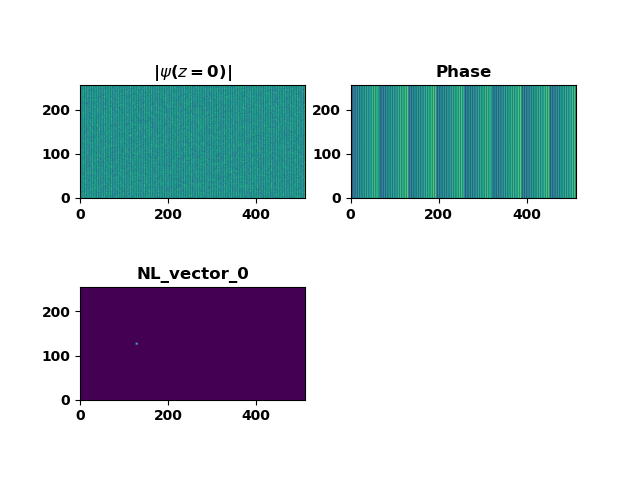

In [5]:
%matplotlib notebook
#plotting a planewave appears wild due to the colorbar
my_simulation.plot(nl_vectors)

## Generate the configuration file

In [6]:
my_simulation.gen_config_file(nl_numbers,nl_vectors)

**Configuring Mesh:
Config folder already exists, skipping mkdir
Configuration file created!
**Configuring Initial Conditions
Initial condition file created!
**Configuring nonlinearities:
Nonlinearities configuration files created!


## Run simulation

Having the engine built previously and added to the folder we can call from the command line to execute it.

Options:

First argument corresponds to backend: 1 - CPU; 2 - OpenCl; 3 - CUDA;

Second argument corresponds to device: 0 - #number of devices available to choose the device

In [7]:
%%cmd
hibpm_run.exe 2 1

Microsoft Windows [Version 10.0.18363.1379]
(c) 2019 Microsoft Corporation. Todos os direitos reservados.

C:\Users\nunoa\Untitled Folder 3>hibpm_run.exe 2 1
Running infoArrayFire v3.6.1 (OpenCL, 64-bit Windows, build b443e14)
[0] NVIDIA: GeForce GTX 1050, 4096 MB
-1- Intel(R) OpenCL HD Graphics: Intel(R) HD Graphics 630, 6507 MB
---scalar field created--- 
Creating a mesh for our problem 
---Mesh created--- 
---Nonlinearities created--- 
---start--- 
Stride 0 of 40
Stride 1 of 40
Stride 2 of 40
Stride 3 of 40
Stride 4 of 40
Stride 5 of 40
Stride 6 of 40
Stride 7 of 40
Stride 8 of 40
Stride 9 of 40
Stride 10 of 40
Stride 11 of 40
Stride 12 of 40
Stride 13 of 40
Stride 14 of 40
Stride 15 of 40
Stride 16 of 40
Stride 17 of 40
Stride 18 of 40
Stride 19 of 40
Stride 20 of 40
Stride 21 of 40
Stride 22 of 40
Stride 23 of 40
Stride 24 of 40
Stride 25 of 40
Stride 26 of 40
Stride 27 of 40
Stride 28 of 40
Stride 29 of 40
Stride 30 of 40
Stride 31 of 40
Stride 32 of 40
Stride 33 of 40
Stride 34 

## Data Analysis

In [8]:
#load the simulation mesh - here we use the data generated , deprecating the previous generated data; 
#they are equivalent, but this way you can adapt the same codes to simulations generated from pure c++ simulations

#load the simulation mesh
my_mesh = mesh(saveDir+"/")

#load the data from data folder
#stride between consecutive loaded files
stride_read = 1
simulation_data,zs = load_data_folder(saveDir+"/gnlse_field/",my_mesh,stride_read)

<IPython.core.display.Javascript object>


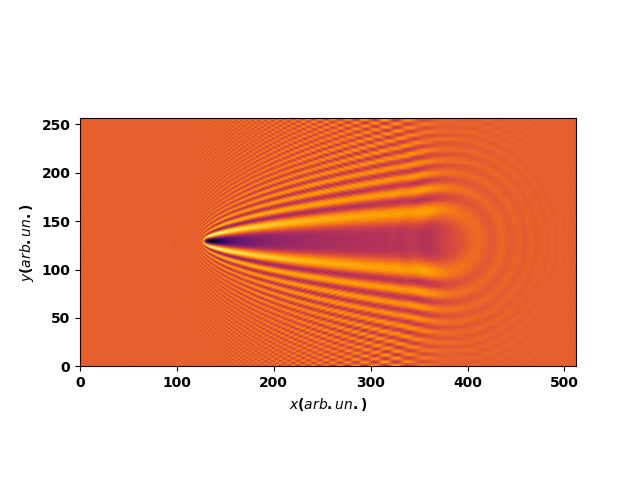

Text(0, 0.5, '$y (arb.un.)$')

In [9]:
figure(3)
imshow(transpose(abs(simulation_data[20])), origin = "lower", extent = [0, my_mesh.lx,0,my_mesh.ly], 
       aspect = my_mesh.dx/my_mesh.dy, cmap = 'inferno')
xlabel(r"$x (arb.un.)$")
ylabel(r"$y (arb.un.)$")

Note that the Fourier space also gives interesting clues for the numerical analysis;

<IPython.core.display.Javascript object>


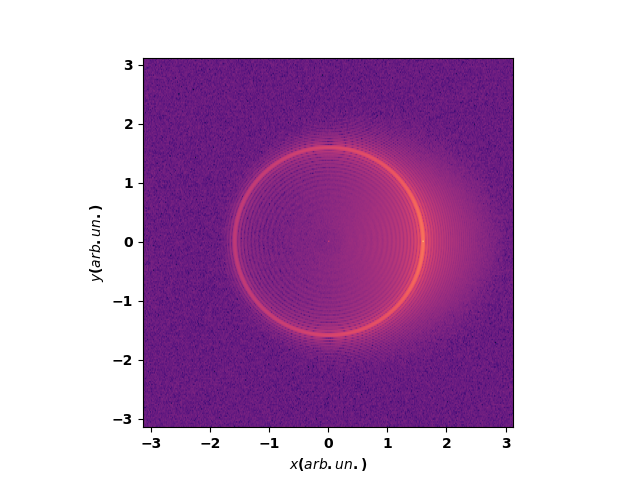

Text(0, 0.5, '$y (arb.un.)$')

In [10]:
figure(4)
fft_field = fft.fftn(simulation_data[10])
fft_field = fftshift(fft_field, axes=(0,1,))
freqx = fft.fftfreq(my_mesh.Nx, d=my_mesh.dx)
freqx = 2*pi*fftshift(freqx)
freqy = fft.fftfreq(my_mesh.Ny, d=my_mesh.dy)
freqy = 2*pi*fftshift(freqy)

imshow(transpose(log10(abs(fft_field))), origin = "lower", extent = [freqx[0],freqx[-1],freqy[0],freqy[-1]], 
       aspect = my_mesh.dx/my_mesh.dy, cmap = 'magma')
xlabel(r"$x (arb.un.)$")
ylabel(r"$y (arb.un.)$")

In [11]:
from tvtk.api import tvtk, write_data
"""
************************************************
VTK file generator
************************************************
"""
#parameters to control the aspect in paraview - increase factors to increase size
factor_x = 1
factor_y = 1
factor_z = 10
factor_t = 1
stride_f = 1
factor_vertical=1


def save_to_vtk_2d(mesh,topview_array,times,saveDir, filename, dataname = "Data"):
    """
    Save a given array to vtk
    """
    

    print("Saving VTK file")
    topview_array=topview_array.transpose((1,2,0))[::2,::2,:][:,:,::1]

    grid = tvtk.ImageData(spacing=(mesh.dx*factor_x,mesh.dy*factor_y,mesh.dz*stride_f*factor_z),origin=(0, 0, 0), dimensions=topview_array.shape)
    grid.point_data.scalars = (abs(topview_array)*abs(topview_array)).ravel(order='F')
    grid.point_data.scalars.name = dataname
    
    # Writes legacy ".vtk" format if filename ends with "vtk", otherwise
    # this will write data using the newer xml-based format.
    write_data(grid, saveDir + '/'+str(filename)+".vtk")
    print("VTK file saved")
    


In [12]:
if not os.path.exists("VTK"):
    os.makedirs("VTK")

my_data,my_zs = load_data_folder(saveDir+"/"+"gnlse_field/",my_mesh,stride_read)
save_to_vtk_2d(my_mesh,my_data,my_zs,"VTK/", "gnlse_field_top_view", dataname = "GNLSE")


Saving VTK file
VTK file saved
